## Exercise set 4: the generalized random forest

In this exercise set we will be working with the [generalized random forest](https://github.com/grf-labs/grf) by Athey et al. The package is written for the R programming language, and while there is a R-to-python interface in [rpy2](https://rpy2.bitbucket.io/) it can be tricky to get working. If you run into trouble, you can consider saving your data to a csv file and work directly in [R](https://www.r-project.org/) through [Rstudio](https://rstudio.com/products/rstudio/download/). 

In [ ]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

To highlight the usefulness of GRF we will be working with synthetic data in this exercise. In particular we will synthetically add a treatment effect to a dataset in which there otherwise is none. Furthermore we will make this effect heterogeneous by adding noise, and by making it depend on a single continuous variable as well as a categorical variable. 

>**Ex. 4.1.1:** Complete the code below to simulate data according to
$$
T = U(0,1) > 0.5 \\ 
Y(T=0) = X\beta + \epsilon \\ 
\tau(X) =  \begin{cases}
        \frac{10}{1 + e^{-\gamma X_0}} + \nu & D = 0\\ 
        \nu & D = 1
        \end{cases}\\ 
Y(T=1) = Y(0) + \tau(X) \\ 
$$
where $\epsilon, \nu$ are simply noise terms distributed according to $\mathcal{N}(0,1)$ and $\beta$ is an `N_FEATURES` vector of random parameters. $\gamma$ is a scalar parameter.


In [98]:
N_SAMPLES = 10000
N_FEATURES = 5
GAMMA = 3
BETA = np.random.uniform(0,1, size = N_FEATURES)

X = np.random.normal(size = (N_SAMPLES, N_FEATURES))
D = np.random.choice([0,1], size = N_SAMPLES)
T = np.random.uniform(0,1, size = N_SAMPLES) > 0.5

Y0 = X @ BETA + np.random.normal()
Tau = (1-D)*10/(1 + np.exp(-GAMMA*X[:,0])) + np.random.normal() 
Y1 = Y0 + Tau 
y = Y0 + T*(Y1 - Y0)

**Ex. 4.1.2:** Create a two-subplot figure, and plot $Y(0)$ and $Y(1)$ in one subplot against $X_0$. Plot $\tau(x)$ against $X_0$ in the other subplot. What do you see? Why do we observe $\tau=0$ in many cases?

Text(0.5, 1.0, 'Baseline and Endline Outcomes vs. Covariate X0')

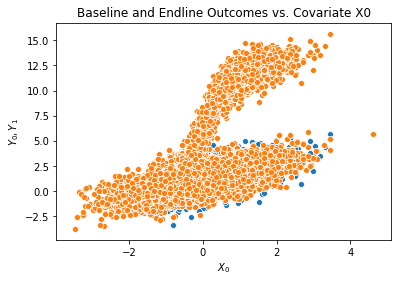

In [99]:
fig1, axes = plt.subplots(1, sharex='all', sharey='all')
sns.scatterplot(X[:,0],Y0)
sns.scatterplot(X[:,0],Y1)
axes.set_ylabel("$Y_0, Y_1$")
axes.set_xlabel("$X_0$")
axes.set_title("Baseline and Endline Outcomes vs. Covariate X0")

Text(0.5, 1.0, 'Treatment effect vs. Covariate X0')

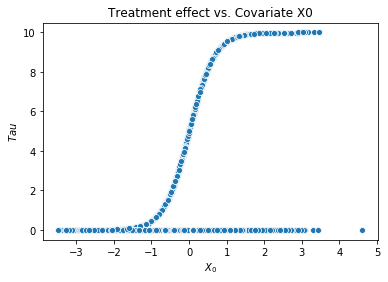

In [100]:
fig1, ax = plt.subplots(1, sharex='all', sharey='all')
sns.scatterplot(X[:,0],Tau)
ax.set_ylabel("$Tau$")
ax.set_xlabel("$X_0$")
ax.set_title("Treatment effect vs. Covariate X0")

>**Ex 4.1.3.** Import `statsmodels` and estimate a simple linear regression
$$
y = \alpha + \delta_0 T + \sum_k \beta_k X_k + \epsilon
$$
>What is your estimate of $\hat{\delta}_0$? How does this number fit with the figures you drew in the previous exercise? Do you have any suggestions for improving the estimate of the model, comment on whether your improvements would provide unbiased estimates of $\tau$? 
>
> **Bonus:** fit your improved model, and relate the parameters you estimate to the figure you plotted in the previous question.

In [101]:
df1 = pd.DataFrame(y)
df2 = pd.DataFrame(X)
df3 = pd.DataFrame(T)

df1 = df1.rename(columns={0: 'y'})
df2 = df2.rename(columns={0: 'X0', 1: 'X1', 2: 'X2', 3: 'X3', 4: 'X4'})
df3 = df3.rename(columns={0: 'T'})

In [102]:
frames = [df1, df2, df3]

In [103]:
data = pd.concat(frames, axis=1, sort=True)
data.head(50)

y        X0        X1        X2        X3        X4      T
0    1.594397  0.796021  0.227114 -0.284362 -0.090776 -1.288948  False
1    6.314900 -0.135413  1.212931  0.363880  1.787212  0.479599   True
2    2.464314 -0.765290  0.130103  2.646734 -0.762112  0.137112  False
3    1.025059  0.117647  0.624843 -1.026365  1.726095 -0.853899   True
4   -0.506117 -0.455490 -0.931737 -0.960525 -0.888395 -0.382474  False
5    0.820057 -0.785153 -0.373145  0.578373 -0.096730  0.455475  False
6    1.518886 -0.669178  0.227666  0.721378  1.489962  0.438616   True
7    1.227730  0.877170 -0.803618 -0.152122 -0.039246 -0.466575  False
8   12.353367  0.984945  0.129966  1.044255  0.666794  0.197809   True
9    1.236693  0.783926 -0.028145 -0.540739 -0.327133 -1.237563  False
10   1.994316  1.052778  1.909038 -1.280443 -1.265843 -1.421834   True
11   0.468753 -0.945100 -0.172054 -0.771651  0.169009  0.499629   True
12   4.558775 -0.254128  1.524889 -0.963129  0.199898  0.721953   True
13   9.452100  0.452699  0.856030 -0.670063 -0.977023 -0.144385   True
14   1.457119 -0.918307  1.132974 -0.186394  1.075944  2.385119  False
15   9.001925  0.604797  0.096556 -2.136978  0.263966  1.007732   True
16   2.459615  1.082806  0.121456  0.365075 -0.169989  0.922975   True
17   0.116816 -2.353650 -0.105221  1.013793 -0.778753  1.372191   True
18   1.345879  0.282883 -0.410065 -0.003757  0.491694  1.020342  False
19   1.123378 -0.221777  0.547798 -0.318132  0.393383 -0.476954   True
20   5.911619  2.837480  2.767774  1.097017 -1.184557  1.591492   True
21   4.328338  1.632242  1.451466  0.929633  2.196048  1.042449  False
22  -0.387923 -1.780748 -0.394147  0.527372 -1.908610 -1.313628  False
23   2.421449  1.407590  1.136912 -0.980097 -0.780606  1.570409   True
24   0.898980 -1.610787  0.536687  0.698862  1.215182  0.074422  False
25   2.425432  1.126372  1.925479 -0.873090 -2.544665  0.209199  False
26   0.454216 -0.585457  0.446915 -1.053663  0.506534  0.890101   True
27   2.476636  1.091696  0.612685  0.254184  0.253577 -1.164297  False
28   2.567697  1.617748  0.144180  0.112269 -0.549713  0.053710   True
29   1.760955  0.094183  1.377789 -0.255476 -0.181408 -1.316961  False
30   1.161193  0.409061  0.047900 -0.447239  0.068615 -0.713225  False
31   3.005600  1.270584 -0.197161  1.156294 -0.717711  1.749707   True
32   0.791841  1.511479 -0.699631 -2.157280  0.493137  2.352734   True
33  10.974156  1.445964 -0.590051 -1.262431 -0.199113  0.285040   True
34   0.848600 -1.792293  1.229543  0.546190 -0.045153 -0.780122  False
35   2.220151  0.542213  0.270339  0.528375 -1.362697  1.641301   True
36   0.945687 -0.689785 -0.881960 -0.601434  0.085663  0.790182   True
37   2.044778  0.467159  1.279799 -0.084964 -1.526904 -0.769807  False
38   0.864503  0.625430 -0.678857 -0.399942  0.134920 -1.202659  False
39   0.656319 -0.552040 -0.791540  0.762704 -2.243039  0.415329   True
40   2.276337 -1.126690 -0.069913  2.305463  1.298297 -0.467295   True
41   2.391600  1.266924  0.673888 -0.182022  0.065894 -0.666822  False
42   2.406761  1.125695 -0.649094  0.915503 -0.020441  0.832886   True
43  -0.480669  0.381254 -1.924593 -1.314804 -0.188267  0.963440   True
44   5.033887  1.977482  2.567091  0.915398  0.580326  0.442211  False
45   1.727167 -0.970093  0.291836  0.842298  0.406729 -0.327124   True
46   6.197696 -0.107554  0.278143  0.899240  1.026082 -0.073140   True
47   0.389253 -1.147876  0.236697 -0.116679 -0.751410 -1.849385   True
48   1.839755  0.794064 -0.479286  0.162790  0.934756  0.934876   True
49  -0.267015 -0.996129 -1.107588 -0.437709  0.212610 -1.823682   True

In [104]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols('y ~ T + X', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     1428.
Date:                Thu, 19 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:51:16   Log-Likelihood:                -22924.
No. Observations:               10000   AIC:                         4.586e+04
Df Residuals:                    9993   BIC:                         4.591e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2102      0.034     35.726      0.0

>**Ex. 4.1.4:** For this question we will need to move into R (or use rpy2). If you are working in python you can skip this step, otherwise do the following. 
>
> Save a dataframe, containing $X$, $y$, $T$, and $D$ as a csv file on your computer.

In [105]:
# Your answer here
!conda install -c r rpy2 -y

Solving environment: ...working... done

# All requested packages already installed.



In [106]:
import rpy2
import rpy2.robjects as robjects

In [107]:
# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('ggplot2', 'hexbin', 'grf')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

>**Ex. 4.1.5:** Open up R and read the data you just saved into a dataframe(or work in rpy2). Install and load the two libraries `tidyverse` and `grf`.
>
> _Hint:_ to install the required packages. run this:
> ```R
> install.packages("tidyverse")
> install.packages("grf")
> ```

In [108]:
# Your answer either here, or in R
from rpy2.robjects.packages import importr
grf = importr('grf')
# tdv = importr('tidyverse')

>**Ex. 4.1.5:** Copy the following code into R to split your dataframe into two matrices, `X`, and `y`. Implement the exact same procedure to create a third matrix `W` which contains the treatment indicator (**Note** `T` is a reserved name in R, so name your third matrix `W`).
>```R
>X <- df %>%
  select(X0, X1, X2, X3, X4, D) %>% 
  as.matrix()
>
>y <- df %>%
  select(y) %>% 
  as.matrix()
>```
> Finally spend some time poking around the [GRF documentation](https://github.com/grf-labs/grf). See if you can figure out how to estimate a GRF model, once you have the three matrices you need (this is way simpler than you might expect).

In [110]:
# Your answer either here, or in R
from rpy2.robjects.packages import importr
grf = importr('grf')

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import rpy2.robjects as ro

X_r = ro.r.matrix(X, nrow=N_SAMPLES, ncol=N_FEATURES)
Y_r = ro.r.matrix(y, nrow=N_SAMPLES, ncol=1)
T_r = ro.r.matrix(T, nrow=N_SAMPLES, ncol=1)

tau_forest = grf.causal_forest(X_r, Y_r, T_r)

>**Ex.4.1.6:** Estimate a causal forest model using the GRF package, and store the result in a new variable `cf`. Then use the following line to create a dataframe of predicted treatment effects on the same data that you trained the model on. 
>```R
>cf <- # Estimate a generalized RF model aimed at treatment effects.
>tau <- predict(cf, X)
>```
> Once you have your individual treatment effects, run the following line, to save them in a csv file. 
> ```R
> write.csv(tau, "individual_treatment_effects.csv")
> ```

In [111]:
# Your answer either here, or in R
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()

X_range = np.zeros([N_SAMPLES,N_FEATURES])
X_range[:,0] = np.linspace(-2,2,N_SAMPLES)
X_range_r = ro.r.matrix(X_range, nrow=N_SAMPLES, ncol=10)

tau_hat_r = ro.r.predict(tau_forest, X_range)
# tau_hat = pandas2ri.ri2py(tau_hat_r)['predictions'].values
print(tau_hat_r)
print(Tau)
len(tau_hat_r)
len(Tau)

      predictions

1      0.02221578

2      0.02221578

3      0.02221578

4      0.02221578

5      0.02221578

6      0.02221578

7      0.02221578

8      0.02221578

9      0.02221578

10     0.02232214

11     0.02232214

12     0.02232214

13     0.02305153

14     0.02349577

15     0.02349577

16     0.02349577

17     0.02349577

18     0.02349577

19     0.02349577

20     0.02348524

21     0.02348524

22     0.02354749

23     0.02354749

24     0.02354749

25     0.02354749

26     0.02370945

27     0.02370945

28     0.02370945

29     0.02370945

30     0.02370945

31     0.02370945

32     0.02370945

33     0.02370945

34     0.02370945

35     0.02370945

36     0.02370945

37     0.02370945

38     0.02370945

39     0.02370945

40     0.02370945

41     0.02370945

42     0.02370945

43     0.02370945

44     0.02370945

45     0.02370945

46     0.02384547

47     0.02384547

48     0.02426828

49     0.02437097

50     0.02437097

51     0.02437097

52     0.024

10000

>**Ex.4.1.6:** This concludes our venture into R. Now load the treatment effects into a pandas dataframe, and plot a scatterplot of the estimated individual treatment effects against the simulated "true" ITE's `Tau` that you produced in the beginning of this exercise set.

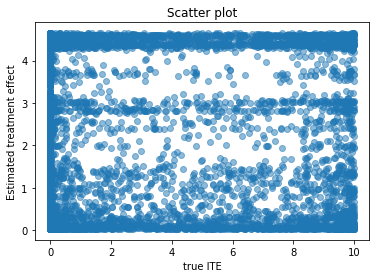

In [112]:
# Your answer either here
# t_effect = pd.DataFrame(tau_hat_r)
plt.scatter(Tau, tau_hat_r, alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('true ITE')
plt.ylabel('Estimated treatment effect')
plt.show()